# 2.03c - Analysis of Night Clusters and BG
This notebook is used to analyse the night clusters and look for indications of BG control during the night.


In [78]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import time
from IPython.display import display

from src.nights import Nights, consolidate_df_from_nights
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample_long = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample_long.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features(multi_threaded=False)
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all[['night_start_date', 'bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max', 'tsne_cluster_label']].rename(columns={'tsne_cluster_label': 'cluster'})
bg_min = 70
bg_max = 180
df_all['bg_min_excursion'] = df_all['bg min'].apply(lambda x: (bg_min - x) if x < bg_min else np.nan)
df_all['bg_max_excursion'] = df_all['bg max'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)

def excursion_type(row):
    if pd.notna(row['bg_min_excursion']) and pd.notna(row['bg_max_excursion']):
        return 'IBR and IAR'
    elif pd.notna(row['bg_min_excursion']):
        return 'IBR'
    elif pd.notna(row['bg_max_excursion']):
        return 'IAR'
    else:
        return np.nan

df_all['bg_excursion_type'] = (df_all[['bg_min_excursion', 'bg_max_excursion']].
                               apply(lambda x: excursion_type(x), axis=1))

2025-07-07 22:49:02.690 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction:   0%|          | 23/6454 [00:00<00:29, 219.37it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  10%|▉         | 637/6454 [00:01<00:10, 536.96it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  11%|█         | 693/6454 [00:01<00:10, 537.16it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  12%|█▏        | 747/6454 [00:01<00:10, 524.93it/s]C:\.env\master_project\Lib\site-p

Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob mean__minimum', 'cob max__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 75 to 2.


BG excursion values are calculated as the difference between the BG min and max values and the target range of 70-180 mg/dL (3.9-10 mmol/l). In both cases, the value is calculated as an absolute value so that magnitude can be compared later on.

In [80]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

We'll first look to see if there is any prevalence of BG excursions in the night clusters. Sleep is considered key to maintaining optimal cardiovascular and metabolic health. The relationship between sleep and glyaecemic control is complex and bi-directional. The effects of disrupted sleep on glucose control \cite{Farabi2016} and - conversely - impact of diabetes treatment on sleep \cite{Brod2013} have been studied but require more research. For instance, studies have associated the rapid decline in blood glucose over short periods with awakenings from sleep \cite{Pillar2003}, but little is known about causation.

By studying the amount of excursions outside a target glucose range, we can get an idea as to the frequency and extent of these excursions. Based on the assumptions given by other research, such excursions may infer - by association - some form of disturbance of sleep. Setting accurate thresholds is not possible when generalising over individuals. Time in range is a good indicator of BG control, but the definition of the ideal range is highly individual. For adults in the UK the general guidance is a target range is between 3.9–10 mmol/l. There are a number of factors that can influence this range however, such as disease duration, comorbities, pregnancy and others \cite{ElSayed2023}. For instance, for individuals in gestation are guided by a 3.5–7.8 mmol/l range, yet we do not have data on most of these influences to personalise the target accordingly. A search of academic papers on guidance for fasting target ranges refers mainly to diagnosis levels rather than guidance for those with T1D though some important institutes do indicate a  and therefore assume a consistent 3.9-10 mmol/l (70-180 mg/dL) concentration range as a general guideline, but this would normally be adjusted for individual needs.

The period we will consider studying once more is the 22:00-06:00 period as defining an arbitrary 'nocturnal' period. This is a period where we would expect the patient to be asleep and therefore not consuming food or taking insulin. Given our intervals are at 30 minutes we cannot accurately measure TOR, but we can look at intervals outside the target range, as well as the level of excursion above or below the target. At each interval we can focus on the BG min and max values at each interval which will have captured the peaks and troughs without smoothing these values, especially if short-lived. We know the OpenAPS system effectively manages BG in patients, so we would expect to see a lower number of excursions in the night clusters compared to the day clusters.

,cluster,bg_excursion_type,bg_excursions
0,0,IAR,823
1,0,IBR,338
2,1,IAR,3035
3,1,IBR,156
4,2,IAR,1003
5,2,IBR,202
6,3,IAR,1149
7,3,IBR,490


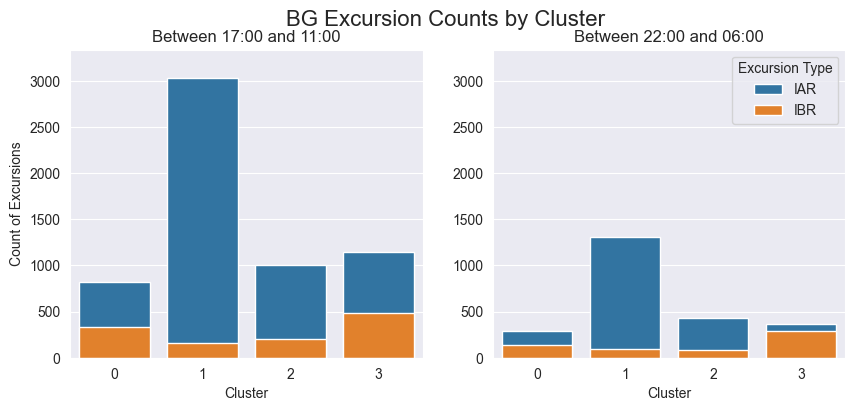

In [81]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('BG Excursion Counts by Cluster', fontsize=16)
df_all_excursion_summary = df_all.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')
display(df_all_excursion_summary)
df_overnight_excursion_summary = df_overnight.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
y_max = df_all_excursion_summary['bg_excursions'].max()
sns.barplot(df_all_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[0], legend=False)
axes[0].set_title('Between 17:00 and 11:00')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count of Excursions')
axes[0].set_ylim(0, y_max * 1.1)

sns.barplot(df_overnight_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[1])
axes[1].set_title('Between 22:00 and 06:00')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel(None)
axes[1].set_ylim(0, y_max * 1.1)

axes[1].legend(title='Excursion Type')
plt.show()


And now a view as to the predominance of these excursions amongst our patients.

In [84]:
# Per-night aggregation: stats and mutually exclusive flags
nightly = (
    df_overnight.groupby(['id', 'night_start_date'])
    .agg(
        max_excursion=('bg_max_excursion', 'max'),
        min_excursion=('bg_min_excursion', 'min'),
        IBR_night=('bg_excursion_type', lambda x: (x == 'IBR').any()),
        IAR_night=('bg_excursion_type', lambda x: (x == 'IAR').any()),
        excursion_count=('bg_excursion_type', lambda x: x.notna().sum()),
        IBR_count=('bg_excursion_type', lambda x: (x == 'IBR').sum()),
        IAR_count=('bg_excursion_type', lambda x: (x == 'IAR').sum())
    )
    .reset_index()
)
# Mutually exclusive flags
nightly['IBR_and_IAR_night'] = nightly['IBR_night'] & nightly['IAR_night']
nightly['IBR_only_night'] = nightly['IBR_night'] & ~nightly['IAR_night']
nightly['IAR_only_night'] = nightly['IAR_night'] & ~nightly['IBR_night']

# Per-patient aggregation
summary = (
    nightly.groupby('id')
    .agg(
        total_nights=('night_start_date', 'nunique'),
        nights_with_excursion=('excursion_count', lambda x: (x > 0).sum()),
        excursion_count=('excursion_count', 'sum'),
        IBR_count=('IBR_count', 'sum'),
        IAR_count=('IAR_count', 'sum'),
        max_excursion_mean=('max_excursion', 'mean'),
        min_excursion_mean=('min_excursion', 'mean'),
        nights_with_IBR=('IBR_only_night', 'sum'),
        nights_with_IAR=('IAR_only_night', 'sum'),
        nights_with_both_IBR_IAR=('IBR_and_IAR_night', 'sum')
    )
)

display(summary)

,total_nights,nights_with_excursion,excursion_count,IBR_count,IAR_count,max_excursion_mean,min_excursion_mean,nights_with_IBR,nights_with_IAR,nights_with_both_IBR_IAR
id,,,,,,,,,,
15558575,42,24,108,32,76,40.894737,5.333333,5,15,4
21946407,48,39,310,23,287,93.666667,9.000000,3,29,7
28768536,41,21,77,68,9,21.333333,3.500000,18,1,2
32407882,63,49,328,5,323,53.250000,2.000000,1,47,1
41131654,150,97,394,256,138,36.590909,4.921875,53,33,11
47323535,51,29,66,19,47,34.166667,8.031250,11,13,5
47750728,39,30,128,18,110,45.280000,4.222222,5,21,4
66836068,38,18,67,22,45,26.818182,4.000000,7,10,1
67208817,48,21,80,5,75,56.000000,8.000000,3,18,0


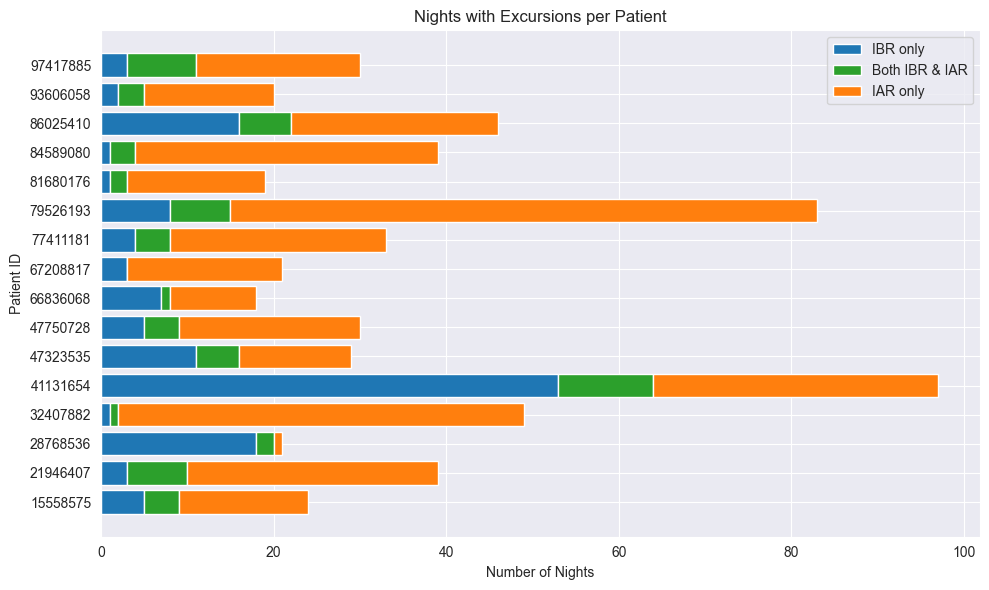

In [85]:
plot_df = summary[['nights_with_IBR', 'nights_with_IAR', 'nights_with_both_IBR_IAR']].copy()
plot_df.index = summary.index  # Ensure patient IDs are the index

fig, ax = plt.subplots(figsize=(10, 6))
ids = plot_df.index.astype(str)
bottom = None

ax.barh(ids, plot_df['nights_with_IBR'], label='IBR only', color='#1f77b4')
ax.barh(ids, plot_df['nights_with_both_IBR_IAR'],
        left=plot_df['nights_with_IBR'],
        label='Both IBR & IAR', color='#2ca02c')
ax.barh(ids, plot_df['nights_with_IAR'], left=plot_df['nights_with_IBR'] + plot_df['nights_with_both_IBR_IAR'], label='IAR only', color='#ff7f0e')

ax.set_xlabel('Number of Nights')
ax.set_ylabel('Patient ID')
ax.set_title('Nights with Excursions per Patient')
ax.legend()
plt.tight_layout()
plt.show()

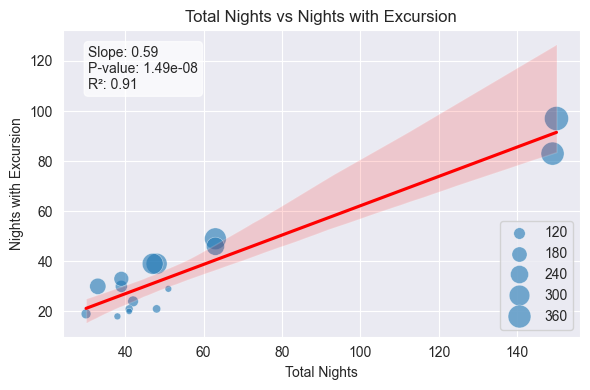

In [86]:
from scipy.stats import linregress

# Prepare data
x = summary['total_nights']
y = summary['nights_with_excursion']

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value ** 2

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    summary, x='total_nights', y='nights_with_excursion',
    size='excursion_count', sizes=(20, 300), alpha=0.6, ax=ax
)
sns.regplot(
    summary, x='total_nights', y='nights_with_excursion',
    scatter=False, ax=ax, color='red', line_kws={'label': 'Fit Line'}
)

# Annotate with coefficient, p-value, and R²
ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nP-value: {p_value:.3g}\nR²: {r_squared:.2f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

plt.title('Total Nights vs Nights with Excursion')
plt.xlabel('Total Nights')
plt.ylabel('Nights with Excursion')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

The first and most notable observation is the high number of excursions that exist, following a linear relationship between the number of nights and the number of excursions. This is not unexpected, as the more nights we have, the more likely we are to have excursions. However, the slope of this line is quite high (with p-value < 5% and R^2 of 0.91), indicating that the number of excursions does increase significantly with the number of nights. This would suggest that this form of indicator will not be particularly accurate at highlighting disturbances in diurnal patterns per se, but rather that the number of excursions is a function of the number of nights. This is not unexpected, as the more nights we have, the more likely we are to have excursions. However, the slope of this line is quite high (with p-value < 5% and R^2 of 0.91), indicating that the number of excursions does increase significantly with the number of nights. This would suggest that this form of indicator will not be particularly accurate at highlighting disturbances in diurnal patterns per se, but rather that the number of excursions is simply a function of the number of nights.

In [88]:
from src.helper import rank_minutes_series

df_hist_excursion = df_overnight[['cluster', 'bg_min_excursion', 'bg_max_excursion']].reset_index().copy()
df_hist_excursion['time'] = df_hist_excursion['datetime'].dt.time
df_hist_excursion['time_rank'] = rank_minutes_series(df_hist_excursion['time'], night_start)
df_hist_excursion = (df_hist_excursion.
                     rename(columns={'bg_min_excursion': 'IBR', 'bg_max_excursion': 'IAR'}).
                     melt(id_vars=['cluster', 'time', 'time_rank'],
                          value_vars=['IBR', 'IAR'],
                          var_name='excursion_type',
                          value_name='excursion_value').
                     dropna(subset=['excursion_value']).
                     sort_values(by='time_rank'))
xticks = df_hist_excursion[['time_rank','time']].set_index('time_rank').drop_duplicates().sort_index()['time']

C:\Users\ross\AppData\Local\Temp\ipykernel_21796\761509557.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Excursion Type')


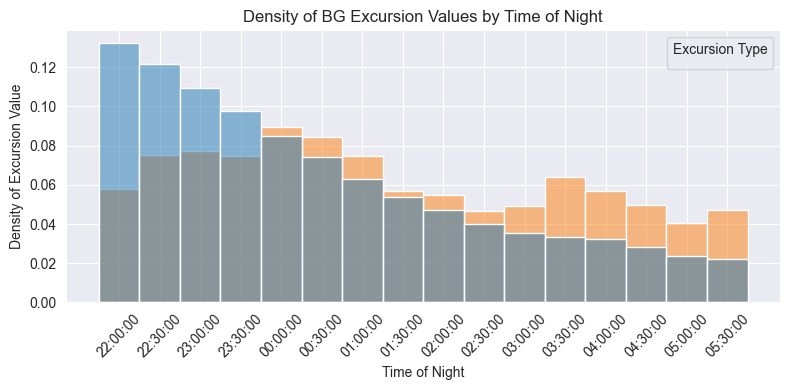

In [89]:
fig = plt.figure(figsize=(8, 4))
sns.histplot(df_hist_excursion, x='time_rank', hue='excursion_type', weights='excursion_value',
             stat='density', common_norm=False, binwidth=30, discrete=True)
plt.xticks(ticks=df_hist_excursion['time_rank'].unique(), labels=xticks, rotation=45)
plt.xlabel('Time of Night')
plt.ylabel('Density of Excursion Value')
plt.title('Density of BG Excursion Values by Time of Night')
plt.legend(title='Excursion Type')
plt.tight_layout()

The density of the excursion value in histogram shows how the magnitude of blood glucose excursions (either IBR or IAR) is distributed across different time intervals during the night, for each cluster. Density means the plot is normalised so the area under the curve (or sum of bar heights) equals 1 for each group, allowing comparison of the shape of the distribution, regardless of the total number or sum of excursions. The excursion value is the amount by which blood glucose is outside the target range (either above or below). It provides a view of t times excursions are more or less likely, and how large they tend to be.

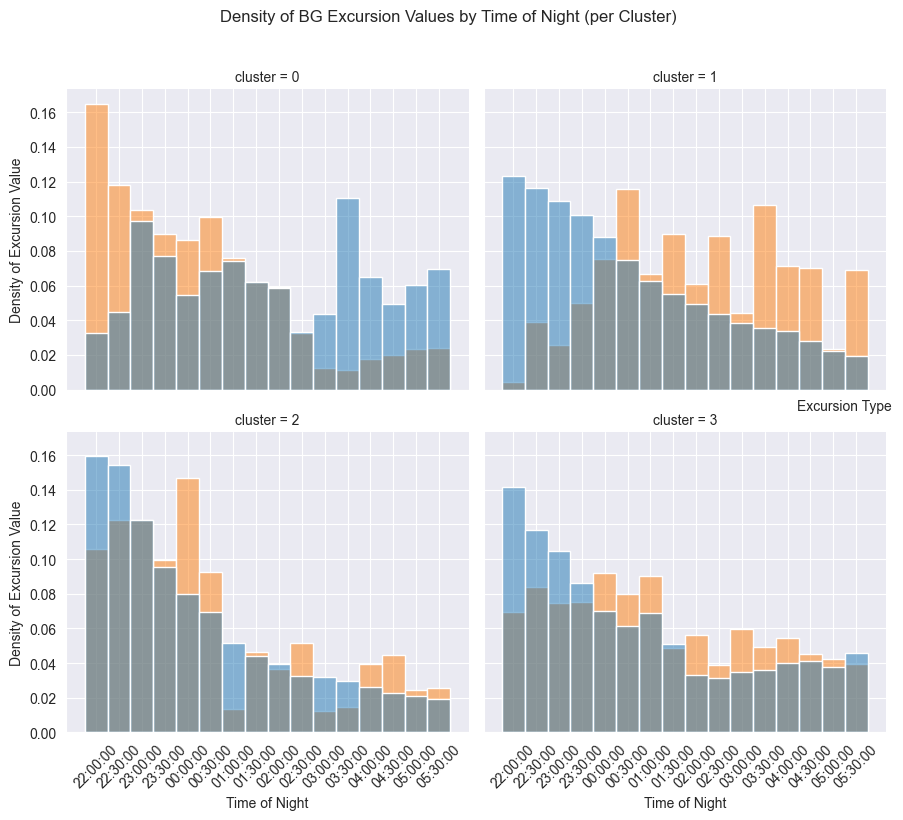

In [90]:
g = sns.FacetGrid(
    df_hist_excursion,
    col='cluster',
    col_wrap=2,
    height=4,
    sharey=True
)
g.map_dataframe(
    sns.histplot,
    x='time_rank',
    hue='excursion_type',
    weights='excursion_value',
    stat='density',
    common_norm=False,
    binwidth=30,
    discrete=True
)
for ax in g.axes.flatten():
    ax.set_xticks(df_hist_excursion['time_rank'].unique())
    ax.set_xticklabels(xticks, rotation=45)
    ax.set_xlabel('Time of Night')
    ax.set_ylabel('Density of Excursion Value')
g.add_legend(title='Excursion Type')
g.fig.suptitle('Density of BG Excursion Values by Time of Night (per Cluster)', y=1.02)
plt.tight_layout()
plt.show()